In [1]:
#---------------------------------------------
# Libraries
#---------------------------------------------
# Built-in libraries
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import wrds
import time
import importlib

#  user-written modules
import loading_data
import rolling_beta
import BAB
import plots
import momentum
import idio_vol
import CAPM_stats
import optimal_fund

In [ ]:
#---------------------------------------------
# Downloading Data (Run this block only once)
#---------------------------------------------
db=wrds.Connection(wrds_username='javadkashizadeh')
# Load data
Rf = loading_data.rf_rate(db)
Rm = loading_data.market_ret(db)
sic_data = loading_data.sic_data(db)
sic_data = sic_data.drop_duplicates(subset=['permno', 'date'], keep='last')
sic_data.to_csv('sic_data.csv', sep=';', index=False)

stock_data = loading_data.stock_data(db)
stock_data = stock_data.drop_duplicates(subset=['permno', 'date'], keep='last')
# Merge and prepare final dataset
data = pd.merge(stock_data, Rf, on='date', how='left')
data = pd.merge(data, Rm, on='date', how='left')
data['const'] = 1
data['Rn_e'] = data['Rn'] - data['rf']
data['Rm_e'] = data['Rm'] - data['rf']
# Export
data.to_csv('raw_data.csv', sep=';', index=False)

In [9]:
# Excluding Reddit-fueled tickers
stocknames = db.raw_sql("""
    SELECT permno, ticker, comnam, namedt, nameenddt
    FROM crsp.stocknames
    WHERE ticker IN ('GME','AMC','BB','NOK','KOSS','EXPR','BBBY','TR','SNDL','CLOV','WISH')
""")

reddit_permnos = stocknames['permno'].unique().tolist()

In [11]:
#---------------
# Rolling Beta
#---------------
project_path = 'G:/My Drive/EPFL/first_year/semester3/Investment/project'

raw_data = pd.read_csv("raw_data.csv",sep=";")
sic_data = pd.read_csv("sic_data.csv",sep=";")


raw_data = raw_data[~raw_data['permno'].isin(reddit_permnos)]

data = raw_data.copy()
a = time.time()
data = rolling_beta.calculate_beta(data)
b= time.time()
print(f'Rolling Beta Calculation took {b-a: 0.2f} seconds')
data = data.dropna(subset=['beta'])

Rolling Beta Calculation took  6.84 seconds


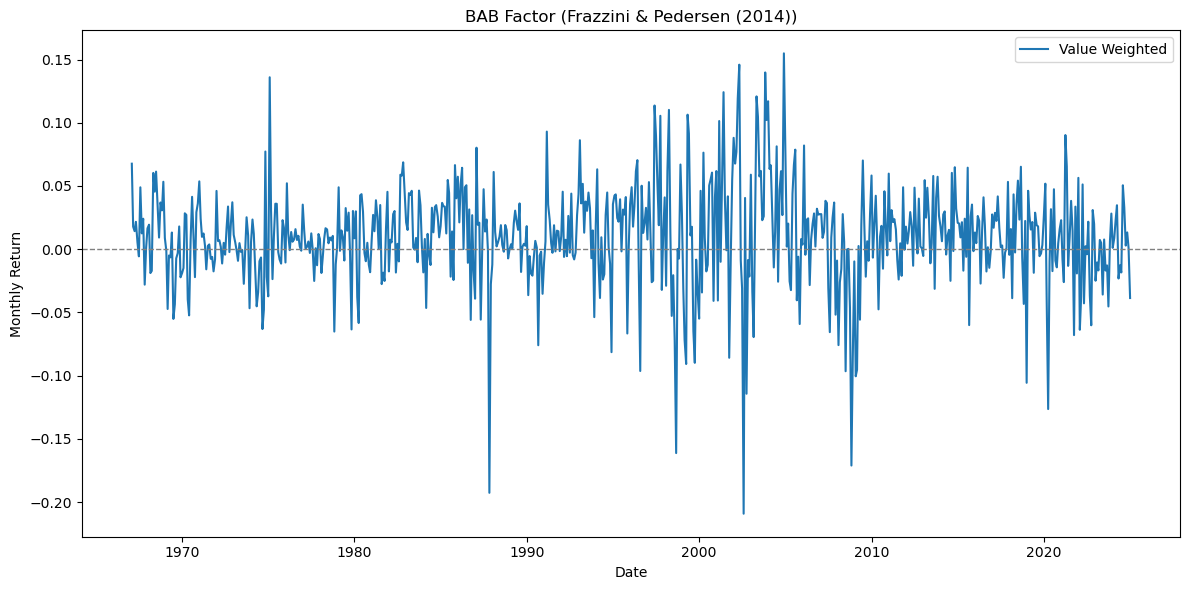

                 Value
monthly_mean  0.009798
annual_std    0.138822
annual_alpha  0.081806
alpha_tstat   5.481930
sharpe_ratio  0.846974
beta          0.515156
idio_vol      0.112578
market_rp     0.069441
market_vol    0.157675


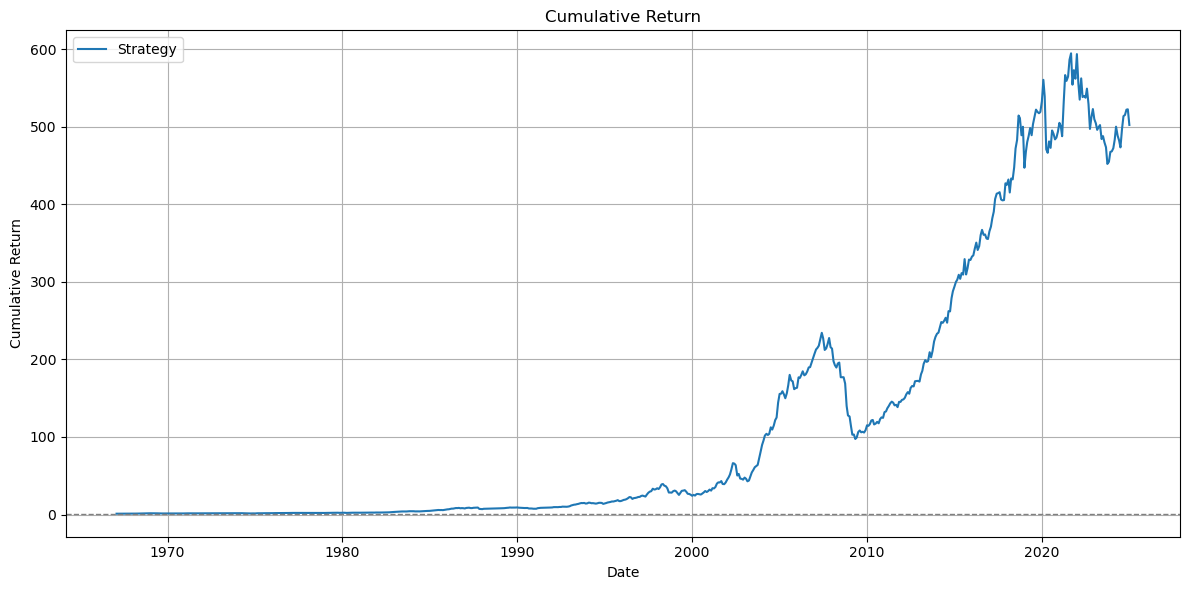

In [13]:
#----------------------------------------------------
# Betting Against Beta (Frazzini & Pedersen (2014))
#----------------------------------------------------
BAB_dataset = data.copy()
BAB_dataset, BAB_factor = BAB.bab_return(BAB_dataset)
plots.signal_returns(BAB_factor, 'date', 'BAB_return', 'BAB Factor (Frazzini & Pedersen (2014))', 'Value Weighted', saving_path=f'{project_path}/BAB.png')
CAPM_stats.factor_statistics(BAB_factor, 'BAB_return', BAB_dataset)
plots.cum_return(BAB_factor, 'BAB_return', saving_path=f'{project_path}/BAB_cum.png')

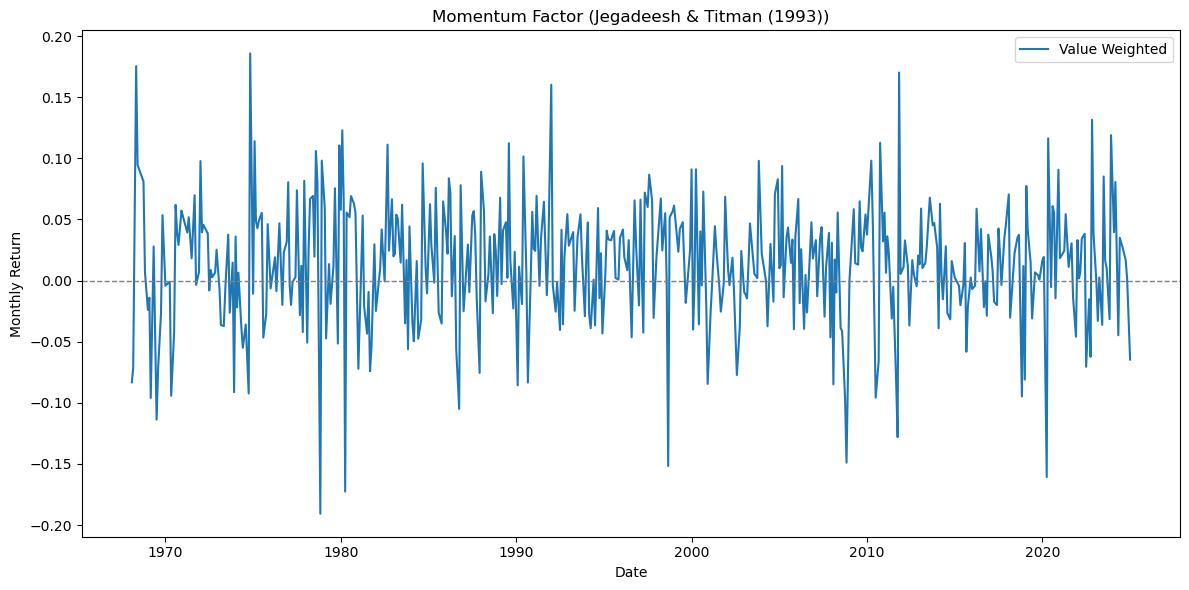

                 Value
monthly_mean  0.013150
annual_std    0.174470
annual_alpha  0.090452
alpha_tstat   7.261837
sharpe_ratio  0.904468
beta          0.976279
idio_vol      0.077846
market_rp     0.068987
market_vol    0.159934


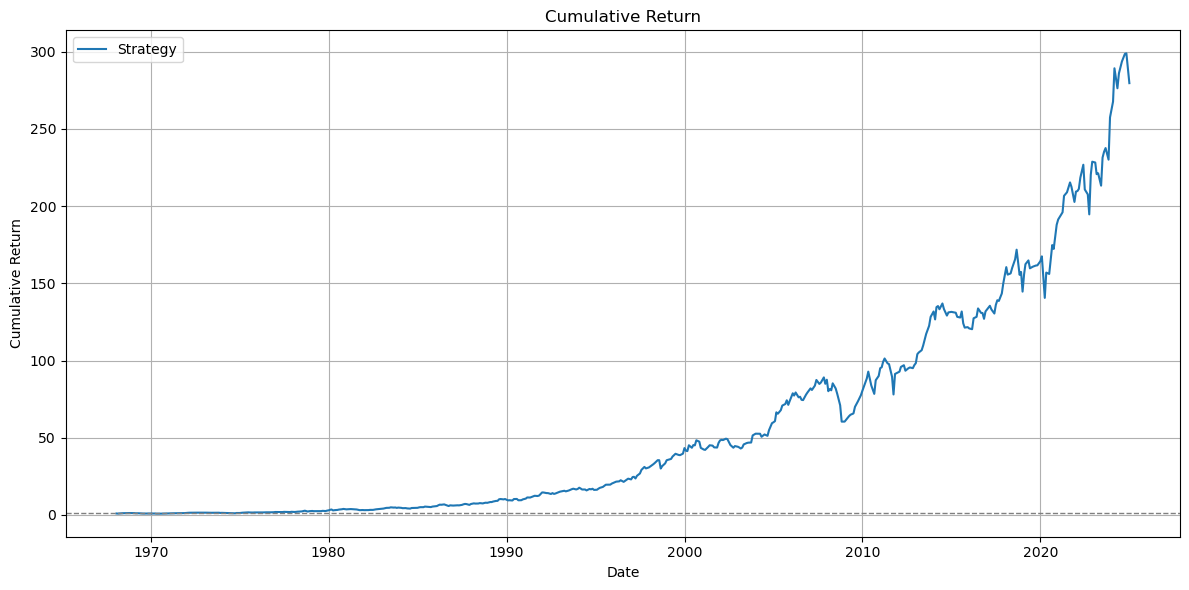

In [15]:
#--------------------------------------------------------
# Momentum Strategy (Jegadeesh & Titman (1993))
#---------------------------------------------------------
mom_dataset = data.copy()
mom_factor = momentum.momentum_portfolio(mom_dataset)
plots.signal_returns(mom_factor, 'date', 'MOM_return', 'Momentum Factor (Jegadeesh & Titman (1993))', 'Value Weighted', saving_path=f'{project_path}/momentum.png')
CAPM_stats.factor_statistics(mom_factor, 'MOM_return', mom_dataset)
plots.cum_return(mom_factor, 'MOM_return', saving_path=f'{project_path}/mom_cum.png')

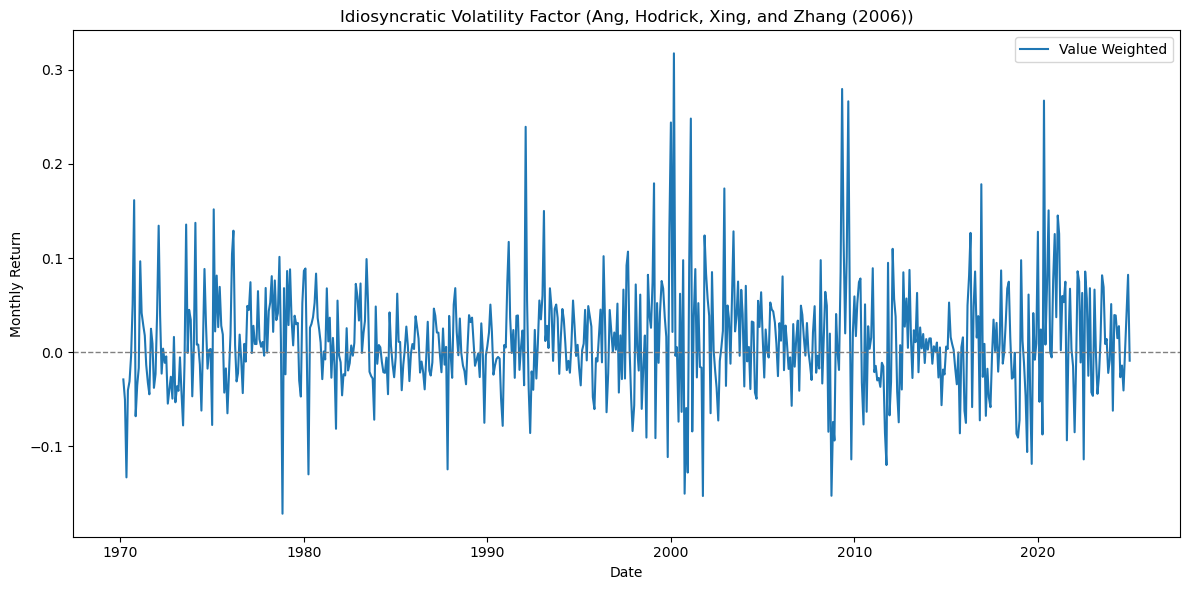

                 Value
monthly_mean  0.012361
annual_std    0.201948
annual_alpha  0.102490
alpha_tstat   4.308070
sharpe_ratio  0.734483
beta          0.640219
idio_vol      0.174680
market_rp     0.071597
market_vol    0.158290


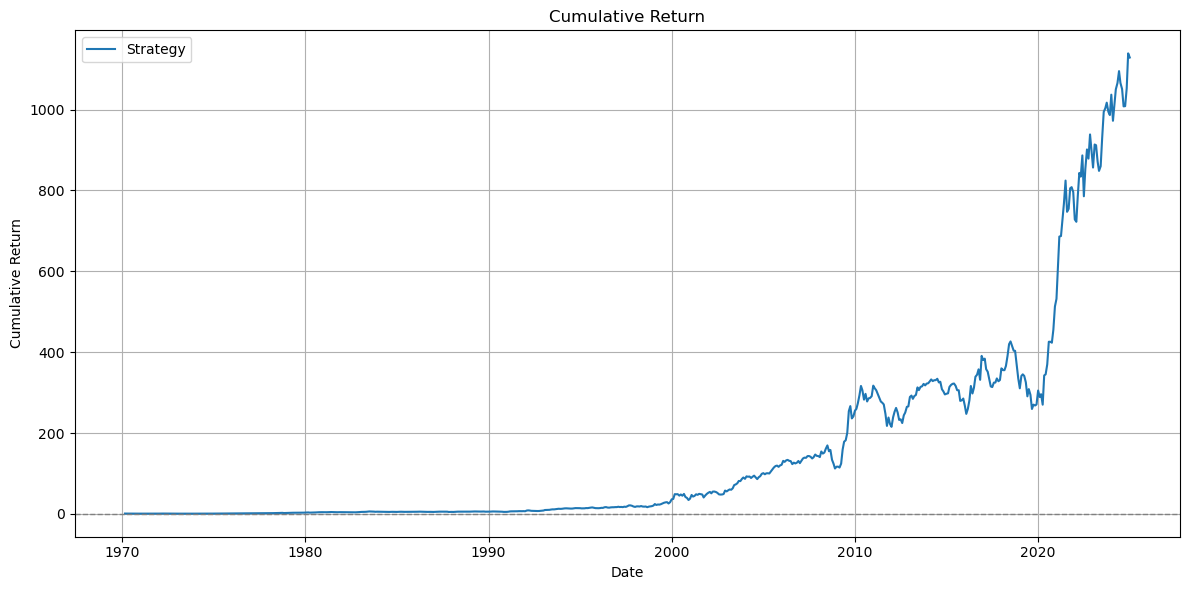

In [16]:
#--------------------------------------------------------------
# Idiosyncratic Strategy (Ang, Hodrick, Xing, and Zhang (2006))
#--------------------------------------------------------------
idio_vol_dataset = data.copy()
idio_vol_factor, short, long = idio_vol.ivol_return(idio_vol_dataset)
plots.signal_returns(idio_vol_factor, 'date', 'IVOL_return', 'Idiosyncratic Volatility Factor (Ang, Hodrick, Xing, and Zhang (2006))', 'Value Weighted', saving_path=f'{project_path}/idio_vol.png')
CAPM_stats.factor_statistics(idio_vol_factor, 'IVOL_return', idio_vol_dataset)
plots.cum_return(idio_vol_factor, 'IVOL_return', saving_path=f'{project_path}/idio_vol_cum.png')

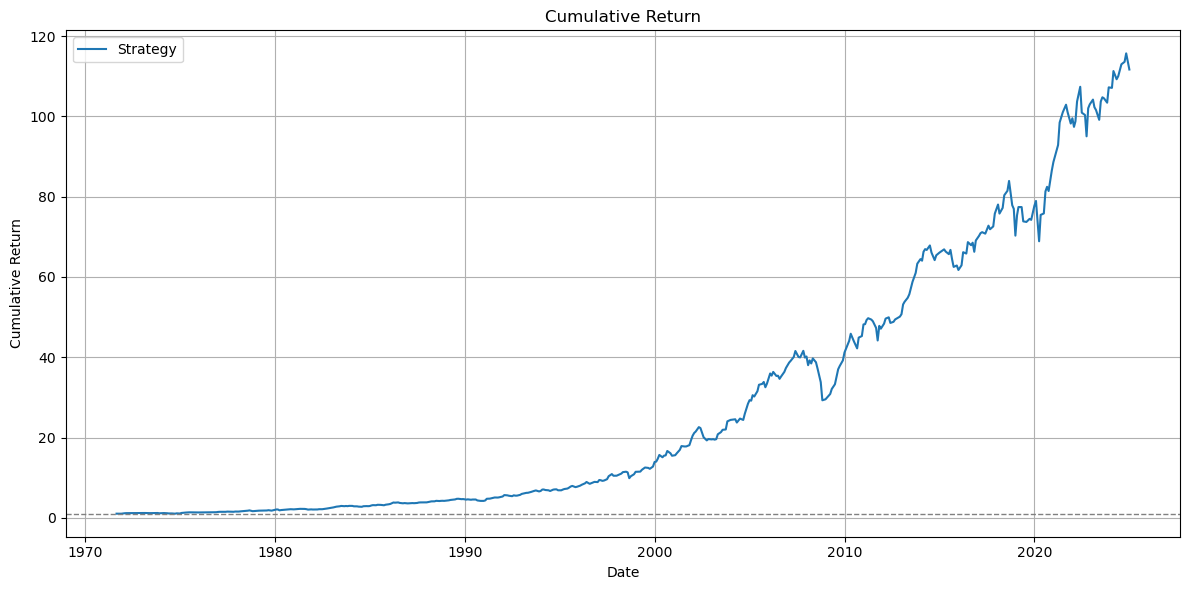

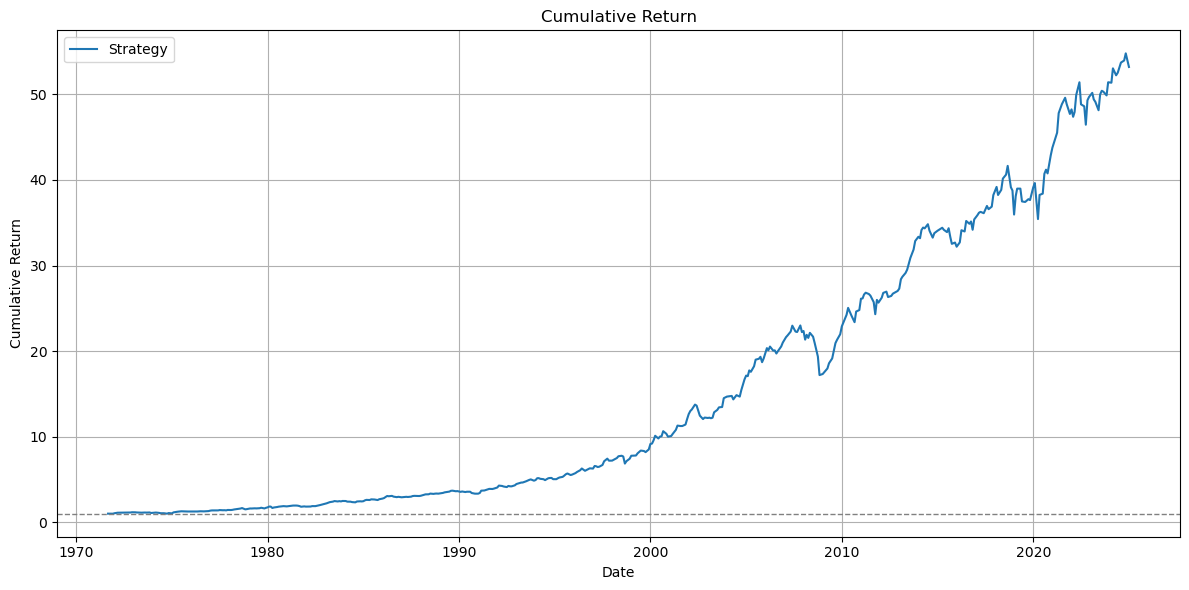

In [18]:
#--------------------------------------------------------------
# Optimal Fund Portfolio
#--------------------------------------------------------------
fund_portfolio = optimal_fund.fund_return(BAB_factor,mom_factor,idio_vol_factor)
CAPM_stats.fund_statistics(fund_portfolio)
plots.cum_return(fund_portfolio, 'rp_return', saving_path=f'{project_path}/rp_cum.png')
plots.cum_return(fund_portfolio, 'rp_return_adj', saving_path=f'{project_path}/rp_adj_cum.png')